In [61]:
src_dir = "../../../src"
import sys
sys.path.append(src_dir)

from install_if_missing import install_if_missing

install_if_missing("shap", verbose=True)

'shap' is already installed.


In [62]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import shap

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

plt.style.use("ggplot")

In [63]:
np.bool = bool

In [64]:
df = pd.read_csv("../session_1/dataset/hnsc_dataset_scaled.csv", index_col = 0)

In [65]:
X = df.drop(["HPV_Status"], axis = 1)
y = df["HPV_Status"]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [67]:
rf_model = RandomForestClassifier(random_state = 42,
                                n_estimators = 100, 
                                max_depth = 100)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, random_state=42)

In [68]:
lr_model = LogisticRegression(random_state = 42, penalty = "l1", solver = "liblinear")

lr_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [69]:
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:,1]

In [70]:
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:,1]

In [71]:
print("Accuracy (Random Forest)")
print(accuracy_score(y_test, y_pred_rf))
print("Accuracy (Logistic Regression)")
print(accuracy_score(y_test, y_pred_lr))

Accuracy (Random Forest)
0.9795918367346939
Accuracy (Logistic Regression)
0.9795918367346939


In [72]:
print("F1-Score (Random Forest)")
print(f1_score(y_test, y_pred_rf, pos_label = "Positive"))
print("F1-Score (Logistic Regression)")
print(f1_score(y_test, y_pred_lr, pos_label = "Positive"))

F1-Score (Random Forest)
0.9883720930232558
F1-Score (Logistic Regression)
0.9882352941176471


In [73]:
test_df = pd.DataFrame(
    {'True': y_test, 'Logistic': y_pred_proba_lr, 'RandomForest': y_pred_proba_rf})

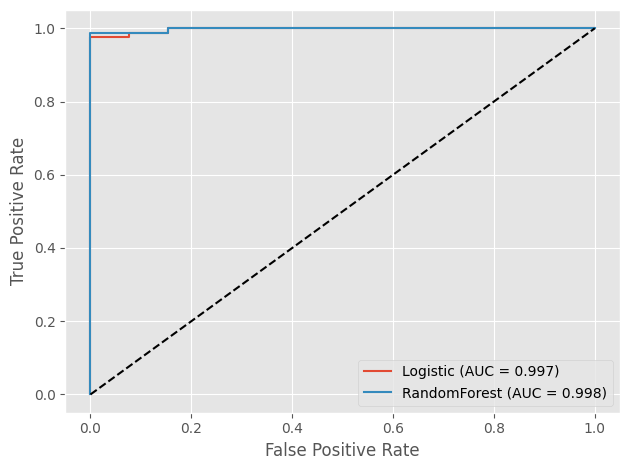

In [74]:
fig, ax = plt.subplots()

for model in ["Logistic", "RandomForest"]: 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_df["True"], test_df[model], pos_label = "Positive")
    roc_auc = roc_auc_score(test_df["True"], test_df[model]) 
    ax.plot(false_positive_rate, true_positive_rate, label = f"{model} (AUC = {roc_auc:.3f})")
    
ax.plot([0, 1], [0, 1], color = 'k', linestyle = '--')
ax.legend()
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
fig.tight_layout()

In [75]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
mean_abs_shap_values = np.mean(abs(shap_values[0]), axis = (0, ))

feature_importances = pd.DataFrame(
                sorted(dict(zip(rf_model.feature_names_in_, mean_abs_shap_values)).items(), 
                    key = lambda x : x[1], 
                    reverse = True),
                columns = ["Gene", "SHAP_Score"]
                )

In [76]:
# Consider top 30 features 
top30_features = feature_importances.iloc[:20,0].to_list()

# Build a model
new_rf_model = RandomForestClassifier(random_state = 42,
                                n_estimators = 100, 
                                max_depth = 100)

new_rf_model.fit(X_train[top30_features], y_train)

y_pred = new_rf_model.predict(X_test[top30_features])
y_pred_proba = new_rf_model.predict_proba(X_test[top30_features])[:,1]

print("Accuracy (Random Forest)")
print(accuracy_score(y_test, y_pred_rf))

print("Accuracy (RF, Biomarkers)")
print(accuracy_score(y_test, y_pred))

print()

print("F1-Score (Random Forest)")
print(f1_score(y_test, y_pred_rf, pos_label = "Positive"))

print("F1-Score (RF, Biomarkers)")
print(f1_score(y_test, y_pred, pos_label = "Positive"))

print()



Accuracy (Random Forest)
0.9795918367346939
Accuracy (RF, Biomarkers)
0.9897959183673469

F1-Score (Random Forest)
0.9883720930232558
F1-Score (RF, Biomarkers)
0.9941520467836257



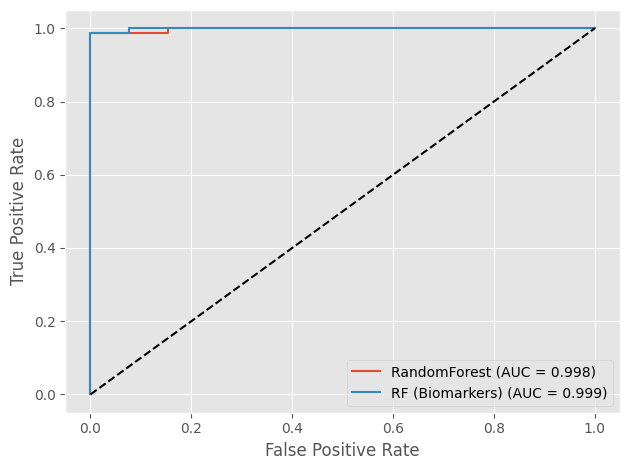

In [77]:
test_df = pd.DataFrame(
    {'True': y_test, 'RF (Biomarkers)': y_pred_proba, 'RandomForest': y_pred_proba_rf})

fig, ax = plt.subplots()

for model in ["RandomForest", "RF (Biomarkers)"]: 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_df["True"], test_df[model], pos_label = "Positive")
    roc_auc = roc_auc_score(test_df["True"], test_df[model]) 
    ax.plot(false_positive_rate, true_positive_rate, label = f"{model} (AUC = {roc_auc:.3f})")
    
ax.plot([0, 1], [0, 1], color = 'k', linestyle = '--')
ax.legend()
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
fig.tight_layout()